# 1. Computation fundamentals

There are several sources of errors in computation: 

- **roundoff**, a consequence of our digital representation of numbers,
- **conditioning**, a property of the problem, and
- **stability**, a property of the algorithm we use.

```{admonition} Additional resource
:class: warning
Trefethen and Bau's **Numerical Linear Algebra**, Chapters 12-14.
```

## 1.1 Floating-point arithmetic

Computers work in terms of floating-point numbers instead of reals $\mathbb{R}$. 

Let's say $\circ$ is an operator that rounds the real number $x \in \mathbb{R}$ to the nearest floating-point number $\tilde{x}$:

$$ \tilde{x} := \circ x. $$

The _absolute_ error induced by this representation is

$$ \Delta x = \circ x - x = \tilde{x} - x, $$
and the _relative_ error is

$$ \delta x = \frac{\Delta x}{x} = \frac{\tilde{x} - x}{x}. $$
We can rearrange this as

$$ \tilde{x} = (1 + \delta x)x. $$

The IEEE (Institute of Electrical and Electronics Engineers) standard _guarantees_ that 

$$ |\delta x| < \mu_M = \tfrac{1}{2}\varepsilon_M, $$
where $\varepsilon_M$ is **machine precision**.

```{admonition} Question
Where does $\varepsilon_M$ come from, and what is it in single and double precision arithmetic?
```

Numbers in floating-point arithmetic are represented as

$$ \pm (1 + f) \cdot 2^n, $$ 
where $n$ is the **exponent** and $(1+f)$ is the **mantissa**. 

A fixed number of bits called the binary **precision**, denoted $d$, is then used to store $f$ in base 2:

$$ f = \sum_{i = 1}^d b_i 2^{-i}, \quad b_i \in \{0, 1\}. $$
It's useful to pull out a constant $2^{-d}$ to get

$$ f = 2^{-d}\sum_{i = 1}^{d} b_i 2^{d - i} = 2^{-d}z, $$
where $z$ is now an integer.

```{admonition} Question
What values can $z$ take? How many numbers are there between $2^n$ and $2^{n+1}$? What does that say about the relationship between $\varepsilon_M$ and $d$?
```

$z$ takes values in $ z \in \{0, 1, 2, \ldots, 2^{d} - 1\}$, therefore there are $2^d$ integers between two adjacent powers of $2$ in floating-point arithmetic. From this we can read off that

$$ \varepsilon_M = 2^{-d}. $$
In single precision, $d = 23$ bits are used to represent the mantissa, therefore $\varepsilon_M \approx 2\cdot 10^{-7}$ and from $\mu_M$ we expect each number to be accurate to around 7 digits. For double precision, $d = 52$ and numbers can be trusted to 16 digits.

## 1.2 Conditioning of a problem; condition number

Conditioning is entirely the property of a problem; it tells you how accurate an anwer you can _expect_ from "ideal" (i.e. backwards-stable) algorithms solving it.


"Problem" in this context is a map:

$$ f: X \to Y, $$
- $X$ is the set of input parameters/space _defining_ the problem (all the information you need to solve it),
- $Y$ is the space of solutions.

$f$ could for example be 
- a function that doubles its input, $f(x) = 2x$, or
- a function that returns the roots of a polynomial defined via a vector $\mathbb{x}$ of its coefficients, or
- a mapping between an initial value problem (say, an ODE and its initial conditions) and its set of solutions.

The conditioning of $f$ is the _sensitivity_ of its output $f(x)$ to perturbations in its input $x$. If the perturbation in the input $x$ is $\delta x$, then the change in the output is $\delta f := f(x + \delta x) - f(x)$.

The **absolute condition number** is defined as
$$ \tilde{\kappa} = \tilde{\kappa}(x) := \lim_{\delta \to 0} \sup_{|\delta x| \leq \delta} \frac{|| \delta f|| }{|| \delta x||} := \sup_{\delta x} \frac{|| \delta f|| }{|| \delta x||}, $$
where the $|| \cdot ||$ denotes the 2-norm.

If $x \in \mathbb{C}^n$, $f \in \mathbb{C}^m$ are $n$- and $m$-dimensional vectors, respectively (meaning: there are multiple inputs and/or outputs), then we can measure how a perturbation in any of the inputs affects any of the outputs via the **Jacobian** matrix $J_{ij} \in \mathbb{C}^{m \times n}$,
$$ \frac{\partial f_i}{\partial x_j} = J_{ij}(x). $$
In this case, as $\tilde{\kappa}(x) = ||J(x)||$.

A more practical quantity is the **relative condition number**, defined as
$$ \kappa(x) := \sup_{\delta x} \frac{||\delta f||/||f(x)||}{||\delta x||/||x||} = \frac{||J(x)||}{||f(x)||/||x||} $$
i.e. as the _relative_ change in output for a small _relative_ change in input.

For scalar functions $f$, this simplifies to $\kappa(x) = \left|\frac{xf'(x)}{f(x)}\right|.$

```{admonition} Question
Why do we care about perturbations in the input? Aren't problems (e.g. functions) mostly defined exactly?
```

Due to floating-point representation (roundoff) error, there is always at least $\mu_M$ relative uncertainty/error in the input. 

```{admonition} Question
What does the condition number depend on? Does it depend on the precision (single, double) we use?
```

The condition number tells you how much this error is amplified by the problem. It is only a function of the problem and the data, and not the algorithm/computer/precision. If the perturbation $\delta x \ll 1$, then 

$$ \frac{||\delta f||}{||f(x)||} \approx \kappa(x) ||\delta x||, $$
so if $\kappa = 10^d$, we expect to lose $d$ digits of accuracy in computing $f$ from $x$.

We say that a problem is
$$
\kappa \begin{cases} &< 10^3 \quad \text{well-conditioned,} \\
&\gg 10^3 \quad \text{ill-conditioned}. \end{cases}
$$

```{admonition} Question
What happens if $\kappa \approx 1/\mu_M$?
```

If $\kappa \approx 1/\mu_M$, we do not expect any useful digits in the answer, and the function $f$ is essentially uncomputable...

```{admonition} Question
What to do if this happens but we still need to compute $f$ to some useful digits?
```
... unless we raise the precision and hence lower $\varepsilon_M$ (e.g. single to double, double to quad).

Let's have a look at the conditioning of some common operations.

```{admonition} Question
What's the condition number of 
- $f(x) = 2x$,
- $f(x) = x^{\alpha}$,
- $f(x_1, x_2) = x_1 - x_2$,
- $f(x) = \sin(x)$ for, say, $x = 10^{100}$,
- $f(x) = Ax$ (where $A$ is an $m \times m$ matrix),
- $f$, if $f(x)$ returns the solution of $Ax = b$ given a matrix $A$ and a vector $b$?
```
1. For $f(x) = 2x$, $J = f' = 2$, so $\kappa = \left|\frac{2x}{2x}\right| = 1$, always well-conditioned.
2. For $f(x) = x^{\alpha}$, $J = f' \propto \alpha$, $\kappa = |\alpha|$ is well-conditioned for reasonable powers $\alpha$,
3. Now there are multiple inputs ($n = 2$) but a single output ($m = 1$), so we have $J = [ 1 -1]$, $||J|| = \sqrt{2},$ and $\kappa = \frac{\sqrt{2}\sqrt{x_1^2 + x_2^2}}{|x_1 - x_2|}$, which $\to \infty$ as $x_1 \to x_2 \neq 0$! So this problem becomes ill-conditioned for close-by inputs. This is a well-known phenomenon called **subtractive** or **catastrophic cancellation**.
4. $f(x) = \sin(x)$, $||J|| \leq 1$, but $\kappa = \frac{||J|||x|}{|\sin(x)|} \geq |x|$ gets huge with increasing $x$. Note, however, that the absolute convergence number is just $\leq 1$.
5. $f(x) = Ax$, so $J = A$. Then $\kappa = ||A|| \frac{||x||}{||Ax||}$. If $A$ is non-singular, $\kappa \leq ||A||||A^{-1}||$, since $||x|| = ||A^{-1} Ax|| \leq ||A^{-1}||||Ax||$. 
```{admonition} Question
When is there an exact equality?
```
6. Solving a linear system. $Ax = b$, so $f(b) = A^{-1}b$. We can use the previous result (replace $A$ with $A^{-1}$) to get $\kappa \leq ||A^{-1}||||A||.$
```{admonition} Question
What was perturbed in the above calculation of $\kappa$? Is there another quantity we can vary and define a cond. no. in terms of?
```
We may also perturb $A$ instead of $b$. If the input is $A$, output is $x$ ($b$ const.), then consider an infinitesimal change in the input, $A + \delta A$ causing an infinitesimal change in output, $x + \delta x$:
$$ (A + \delta A)(x + \delta x) = b, $$
$$ Ax + \delta A x + A \delta x + \delta A \delta x = b. $$
Ignore the last term on the LHS (correct to first order) and cancel the $Ax = b$ to get
$$ \delta x = -A^{-1}\delta A x, $$
therefore $\frac{||\delta x||}{||x||} \leq ||A^{-1}||||\delta A||,$ and $\kappa \leq ||A^{-1}||||A||$ again. 


## 1.3 Stability

Stability is entirely the property of the algorithm used to solve a problem. If an algorithm is stable, this loosely means that it gets the right answer, even if it is not exact.

Let's say we have a fixed
- problem, $f: X \to Y$, e.g. $y = \sin x$ or $y$ solves $Ay = b$,
- floating-point repserentation (with a given precision),
- algorithm for $f$, a map $\tilde{f}: X \to Y$, with steps
$$ x \to \circ x \to \tilde{f} (x). $$

Then the relative error of the computation is 
$$ \frac{|| \tilde{f}(x) - f(x)||}{||f(x)||}. $$
The algorithm is definitely good if this answer is $\mathcal{O}(\mu_M)$ (read: "of the order of").
```{admonition} Aside
Formally, the "big O" notation means that there exists a constant $c$ such that answer is $\leq c\mu_M$ as $\mu_M \to 0$, uniformly over all input data $x \in X$.
```
```{admonition} Question
Is it reasonable to demand this?
```
If the problem, however, is ill-conditioned, this is not a reasonable ask. Even if the algorithm were to give an exact answer, the answer will not have a relative error of $\mathcal{O}(\mu_M)$.

So instead we define and algorithm as **stable** if $\forall x \in X$, 
$$ \frac{||\tilde{f}(x) - f(\tilde{x})||}{||f(\tilde{x})||} = \mathcal{O}(\mu_M) \quad \text{for some }\tilde{x}\text{ such that}\quad \frac{||\tilde{x} - x||}{||x||} = \mathcal{O}(\mu_M).  $$


Meaning that the algorithm gives "nearly the right answer to nearly the right question".

A stronger requirement for an algorithm is to be **backwards stable**, i.e. $\forall x \in X$
$$ \tilde{f}(x) = f(\tilde{x}) \quad \text{for some }\tilde{x}\text { such that}\quad \frac{||\tilde{x} - x||}{||x||} = \mathcal{O}(\mu_M), $$
in words, it is a requirement for the algorithm to give "exactly the right answer to the nearly right question".

The expression "backwards stable" comes from the related concept of **backward error**. Using the above notation, if there is a value $\tilde{x}$ such that $\tilde{f}(x) = f(\tilde{x})$, then the relative backward error is
$$\frac{||\tilde{x} - x||}{||x||}, $$
whereas the absolute backward error is $||\tilde{x} - x||$. 
But why is it called "backward"? The name comes from the fact that this error measures the deviation from the original input/data $x$ that reproduces the result that was found by the algorithm. [Fig. 1.4.1.](https://tobydriscoll.net/fnc-julia/intro/stability.html#fig-backwarderror) from Driscoll and Braun's Fundamentals of Numerical Computation illustrates the relationship between the absolute error $||\tilde{f}(x) - f(x)||$ and the absolute backward error $||\tilde{x} - x||$:
```{image} img/backwarderror.svg
:name: backwarderror-fig
:align: center
```

```{admonition} Question
Is the floating-point subtraction, $\ominus$ backwards stable?
```
- The exact problem is $f(x_1, x_2) = x_1 - x_2$.
- The algorithm is $\tilde{f}(x_1, x_2) = \circ{x_1} \ominus \circ{x_2} = \left[x_1(1+\varepsilon_1) - x_2(1 + \varepsilon_2)\right](1 + \varepsilon_3)$, where $|\varepsilon_i| \leq \mu_M$ for each $i = 1, 2, 3.$
- By renaming, write as $x_1(1 + \varepsilon_4) - x_2(1 + \varepsilon_5)$, where $|\varepsilon_j| \leq 2\mu_M$ for $j = 4, 5$, which is $f(\tilde{x}_1, \tilde{x}_2)$, i.e. exact for some data close to $x_1$, $x_2$. 
The subtraction algorithm is therefore backwards stable.

```{admonition} Question
Can backwards stable algorithms produce large relative errors $\frac{||\tilde{f}(x) - f(x)||}{||f(x)||}$? If so, how?
```
Absolutely! The only way this can happen though, is if $\kappa$ is very large. An important result is that 

```{admonition} Theorem
:class: hint
If a backwards stable algorithm using floating-point representation is used to solve problem $f(x)$ with relative condition number $\kappa(x)$, then the resulting relative error satisfies
$$ \delta := \frac{||\tilde{f}(x) - f(x)||}{||f(x)||} = \mathcal{O}(\kappa(x)\mu_M).$$
```

**Proof:** Backwards stability means that 
$$ \tilde{f}(x) = f(\tilde{x}) $$
for some $\frac{||x - \tilde{x}||}{||x||} = \mathcal{O}(\mu_M)$.
Using this to replace the $\tilde{f}(x)$ with $f(\tilde{x})$ in the relative error and using the definition of $\kappa$ we get  
$$ \delta = \frac{||f(\tilde{x}) - f(x)||}{||f(x)||} \leq \kappa(x)\frac{||x - \tilde{x}||}{||x||} = \kappa(x)\mathcal{O}(\mu_M). $$

Let's revisit the subtraction example to see this in action:

In [15]:
x1 = 3.0000000000006
x2 = 3.0000000000005
 
x1 - x2

9.992007221626409e-14

We see a large relative error (we know the correct answer is $10^{-13}$) in the computed vs. the exact answer, but we have shown that subtraction is backwards stable. The result is entirely due to the large $\kappa$ of the problem. If $x_1$ were only about $8\cdot 10^{-17}$ larger though, which is a small difference relative to the true $x_1$ (a small backward error), the answer produced by the algorithm would be correct. Meaning: it found an exact solution to a nearby problem, the best thing we can hope for when dealing with an ill-conditioned problem. 

```{admonition} Question
Consider the polynomial 
$$ p(x) = (x-2)^9 = x^9 - 18x^8 + 144x^7 - 672x^6 + 2016x^5 - 4032x^4 + 5376x^3 - 4608x^2 + 2304x - 512. $$
If I were to evaluate $p$ at the points $x = 1.920, 1.921, \ldots, 2.080$ via its coefficients, and overlaid evalutations of $p$ at the same nodes via $(x - 2)^9$, what would you expect to see and why?
```

Let's check this:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

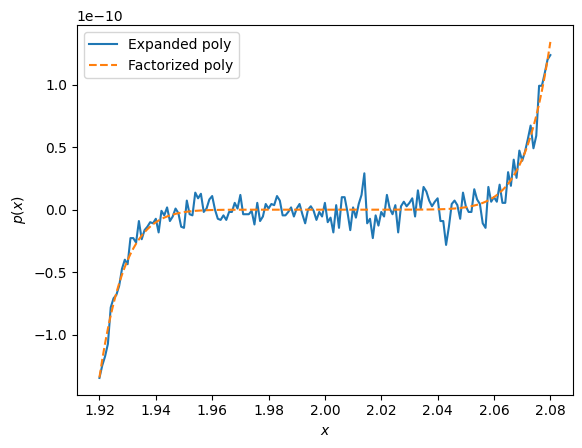

In [3]:
# Expanded poly
p_exp = lambda x: x**9 - 18*x**8 + 144*x**7 - \
                  672*x**6 + 2016*x**5 - 4032*x**4 + \
                  5376*x**3 - 4608*x**2 + 2304*x - 512
# Factorized poly
p_fact = lambda x: (x - 2)**9

x = np.arange(1.920, 2.080, 0.001)
p_exp_arr = p_exp(x)
p_fact_arr = p_fact(x)

plt.figure()
plt.plot(x, p_exp_arr, label = "Expanded poly")
plt.plot(x, p_fact_arr, '--', label = "Factorized poly")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.legend()
plt.show()

What's going on? We are very close to the roots of the poynomial, so the scale of the $y$-axis is $10^{-10}$, and we observe differences between the two evaluation methods of order $10^{-11}$, with the factorized evaluation giving a visibly smoother curve.

The jitter in the expanded polynomial is due to huge catastrophic cancellation. The coefficients of the polynomial are up to $\approx 10^5$, and they are all input parameters, with respect to which (or wrt $x$) the condition number of $p(x)$ is large (_check this yourself!_). Imagine if you were a computer: you would need to convert all those input data (the coeffs and $x$) to floating-point numbers first, introducing some rounding error, which then gets magnified by the large $\kappa$. 

On the other hand, $(x-2)^9$ only takes in $3$ parameters, and we have seen that neither $x - 2$ (with $x$ close to $2$), nor $x^9$ has a dramatically high condition number (only $\approx 10^2$). The algorithms involved (addition, subtraction) are stable, so error can only creep in through poor conditioning.

```{admonition} Exercises
:class: danger

1. If the relative condition number of the real-valued functions $f$ and $g$ are $\kappa_f$ and $\kappa_g$ respectively, show that for $h(x) = f(g(x))$, 

$$\kappa_h(x) = \kappa_f(g(x))\kappa_g(x).$$


2. The polynomial $p(x) = a_0 + a_1x + \ldots + a_nx^n$ has a root $x = r$. What is the (relative) condition number of the root $r$ with respect to perturbations in the coefficient $a_k$, keeping all other coefficients constant? Simplify your answer as much as possible. Deduce when root finding problems become ill-conditioned (there are multiple cases here!).


3. Consider the machine algorithm (that uses floating-point representation) for subtracting $1$ from a real number. You'll investigate whether it's stable and backwards stable.

    a) The exact problem (a mapping $f: X \mapsto Y$) is $ f(x) = 1 - x. $
Write down in words the steps of the machine algorithm $\tilde{f}$ that computes the difference. Express $\tilde{f}(x)$ in terms of the input $x$.

    b) What does $\tilde{f}(x)$ have to equal, in terms of a floating-point number close to $x$ denoted $\tilde{x},$ for the algorithm to be _backwards stable_?

    c) By expressing $\tilde{x}$ in terms of $x$ and some small relative roundoff error $\varepsilon$ ($|\varepsilon| \leq \mu_M$), eliminate $\tilde{x}$ from the above result. To **first order** in small quantities, what does $\varepsilon$ have to equal for backwards stability? Is this $\varepsilon$ **always** $\mathcal{O}(\mu_M)$ (i.e. for all $x$, uniformly)? What does this mean for the backwards stability of this algorithm?

    d) What is the condition for _stability_ in terms of $f$, $\tilde{f}$, $x$, and $\tilde{x}$? 

    e) Is this algorithm stable? Show your work. 
```